<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 80

# Student 1: Thom Crielaard - 1754017

# Student 2: Tobias Sagis - 1333151

# Student 3: Ivan Horn - 0807338

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

from zipfile import ZipFile
import requests
import io

C:\Users\Tobias\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

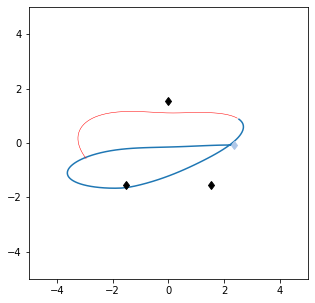

Charges are [-0.89584645 -0.39386724 -0.86287267]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# General dataloader class

Used for both task 3.1 as well as 3.2

In [8]:
class CustomDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor

    def __len__(self):
        return len(self.input_tensor)

    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx]

# Task 3.1

## Data Handling and Preprocessing

In [9]:
# Simulation cutoff point (90 positions) 
cutoff = 90

# Populate the dataset
simulations_train_3_1 = []
for i in range(800):
    trajectory = torch.Tensor(simulation_train[i]).type(torch.FloatTensor).cuda()
    simulations_train_3_1.append(trajectory[range(cutoff)])

simulations_validation_3_1 = []
simulations_test_3_1 = []
for i in range(100):
    trajectory_validation = torch.Tensor(simulation_valid[i]).type(torch.FloatTensor).cuda()
    simulations_validation_3_1.append(trajectory_validation[range(cutoff)])
    trajectory_test = torch.Tensor(simulation_test[i]).type(torch.FloatTensor).cuda()
    simulations_test_3_1.append(trajectory_test[range(cutoff)])

In [10]:
# Construct dataloaders
train_dataset_3_1 = CustomDataset(simulations_train_3_1, torch.Tensor(charges_train).type(torch.FloatTensor).cuda())
train_dataloader_3_1 = DataLoader(train_dataset_3_1, batch_size=1, shuffle=True)

validation_dataset_3_1 = CustomDataset(simulations_validation_3_1, torch.Tensor(charges_valid).type(torch.FloatTensor).cuda())
validation_dataloader_3_1 = DataLoader(validation_dataset_3_1, batch_size=1, shuffle=False)

test_dataset_3_1 = CustomDataset(simulations_test_3_1, torch.Tensor(charges_test).type(torch.FloatTensor).cuda())
test_dataloader_3_1 = DataLoader(test_dataset_3_1, batch_size=1, shuffle=False)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_12124\872846488.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  train_dataset_3_1 = CustomDataset(simulations_train_3_1, torch.Tensor(charges_train).type(torch.FloatTensor).cuda())


## Model Implementation

In [11]:
class simpleModel(nn.Module):
    def __init__(self):
        super(simpleModel, self).__init__()

        # Input layer
        self.linear = nn.Linear(180, 256)
        
        # Hidden layer
        self.linear2 = nn.Linear(256, 128)
        
        # Output layer
        self.linout = nn.Linear(128, 3)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input):
        out = self.linear(input)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linout(out)
        
        return out

## Model Training

In [12]:
# User-defined hyperparameters
model = simpleModel().cuda()

criterion = nn.L1Loss()
learning_rate = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Number of epochs to train for
epochs = 200

loss_training_per_epoch = np.empty((epochs, 1))
loss_validation_per_epoch = np.empty((epochs, 1))
error_training_per_epoch = np.empty((epochs, 3))

for epoch in range(epochs):
    total_loss = 0
    total_eval_loss = 0
    total_error = 0

    # Set in train mode
    model.train()
    
    # Train the model
    training_iterator = iter(train_dataloader_3_1)
    for i in range(len(training_iterator)):
        x, y = next(training_iterator)
        
        # Propagate forward
        output = model(torch.flatten(x[0]))

        # Compute loss
        loss = criterion(output, y[0])
        total_loss += loss.item()

        # Store error per for each prediction [c2 c3 c4]
        expected = y[0].cpu().numpy()
        predicted = output.cpu().detach().numpy()
        total_error += expected - predicted

        # Backward propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Set in eval mode
    model.eval()

    # Evaluate loss on validation set
    validation_iterator = iter(validation_dataloader_3_1)
    for i in range(len(validation_iterator)):
        with torch.no_grad():
            x, y = next(validation_iterator)

            # Propagate forward
            output = model(torch.flatten(x[0]))

            # Compute loss
            loss = criterion(output, y[0])
            total_eval_loss += loss.item()

    average_training_loss = total_loss / len(training_iterator)
    average_eval_loss = total_eval_loss / len(validation_iterator)
    average_training_error = total_error / len(training_iterator)

    loss_training_per_epoch[epoch] = average_training_loss
    loss_validation_per_epoch[epoch] = average_eval_loss
    error_training_per_epoch[epoch] = average_training_error

    print(f'epoch: {epoch+1}, \tMean training loss: {average_training_loss}, \tMean eval loss: {average_eval_loss}')

epoch: 1, 	Mean training loss: 0.26842892448534256, 	Mean eval loss: 0.18384335592389106
epoch: 2, 	Mean training loss: 0.19358394524548203, 	Mean eval loss: 0.17180829871445893
epoch: 3, 	Mean training loss: 0.1750991503847763, 	Mean eval loss: 0.17967822317034007
epoch: 4, 	Mean training loss: 0.1673958437796682, 	Mean eval loss: 0.15069447357207535
epoch: 5, 	Mean training loss: 0.15776300623547285, 	Mean eval loss: 0.1275269971229136
epoch: 6, 	Mean training loss: 0.15327717665582896, 	Mean eval loss: 0.11956622861325741
epoch: 7, 	Mean training loss: 0.1475250431743916, 	Mean eval loss: 0.118644213443622
epoch: 8, 	Mean training loss: 0.1422674392920453, 	Mean eval loss: 0.10582474660128355
epoch: 9, 	Mean training loss: 0.14294918548315763, 	Mean eval loss: 0.11715912591665983
epoch: 10, 	Mean training loss: 0.13930942082661205, 	Mean eval loss: 0.11973174260929227
epoch: 11, 	Mean training loss: 0.1393197107501328, 	Mean eval loss: 0.10986587338149548
epoch: 12, 	Mean training l

epoch: 93, 	Mean training loss: 0.10896512914332561, 	Mean eval loss: 0.06727827063761652
epoch: 94, 	Mean training loss: 0.10406996331876144, 	Mean eval loss: 0.07547140855342149
epoch: 95, 	Mean training loss: 0.10380488643422722, 	Mean eval loss: 0.09125557025894522
epoch: 96, 	Mean training loss: 0.10405322408885695, 	Mean eval loss: 0.07869371885433793
epoch: 97, 	Mean training loss: 0.10718528929166496, 	Mean eval loss: 0.08174196463078261
epoch: 98, 	Mean training loss: 0.10409943886101246, 	Mean eval loss: 0.07968671523034572
epoch: 99, 	Mean training loss: 0.10422837380319834, 	Mean eval loss: 0.08890565280802548
epoch: 100, 	Mean training loss: 0.10525053095130715, 	Mean eval loss: 0.07950738108716905
epoch: 101, 	Mean training loss: 0.10379090973292478, 	Mean eval loss: 0.07412990869954228
epoch: 102, 	Mean training loss: 0.10480342281865887, 	Mean eval loss: 0.08249209297820925
epoch: 103, 	Mean training loss: 0.10355181433726102, 	Mean eval loss: 0.07979927245527506
epoch:

epoch: 184, 	Mean training loss: 0.09923596438835375, 	Mean eval loss: 0.07784630452282727
epoch: 185, 	Mean training loss: 0.09846482489840128, 	Mean eval loss: 0.07930937835946679
epoch: 186, 	Mean training loss: 0.09876383642316795, 	Mean eval loss: 0.08888224266469479
epoch: 187, 	Mean training loss: 0.09664801717270166, 	Mean eval loss: 0.08617080587893725
epoch: 188, 	Mean training loss: 0.09849345637718215, 	Mean eval loss: 0.07935173943638801
epoch: 189, 	Mean training loss: 0.09679157066449989, 	Mean eval loss: 0.0706042904779315
epoch: 190, 	Mean training loss: 0.09831715023668948, 	Mean eval loss: 0.07320091809146106
epoch: 191, 	Mean training loss: 0.09876918126014061, 	Mean eval loss: 0.07508818241767586
epoch: 192, 	Mean training loss: 0.09974794531124644, 	Mean eval loss: 0.06486975719220936
epoch: 193, 	Mean training loss: 0.09752269068150782, 	Mean eval loss: 0.07997530303429812
epoch: 194, 	Mean training loss: 0.0977846049173968, 	Mean eval loss: 0.07472343883477152
e

## Evaluation

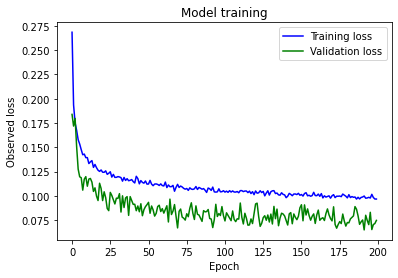

In [13]:
# Plot the loss curve
plt.figure()
plt.plot(range(epochs), loss_training_per_epoch, "b-", label="Training loss")
plt.plot(range(epochs), loss_validation_per_epoch, "g-", label="Validation loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Observed loss")
plt.title("Model training")
plt.show()

In [14]:
# Evaluate the model performance

# number of example predictions
nr_predictions = 100

# Set model to eval mode
model.eval()

prediction_error = np.empty((nr_predictions, 3))
for example_prediction in range(nr_predictions):
    # Get a random index
    index = random.choice(range(len(simulation_test)))
    
    # Get corresponding tensors
    particle_positions = torch.tensor(simulation_test[index][0:90]).type(torch.FloatTensor).cuda()
    particle_charges = torch.tensor(charges_test[index]).type(torch.FloatTensor).cuda()
    
    # Forward propagate the particle positions through the model
    with torch.no_grad():
        predicted_charges = model(torch.flatten(particle_positions))
        
        # Store prediction result in error
        prediction = predicted_charges.cpu().numpy()
        expected = particle_charges.cpu().numpy()
        prediction_error[example_prediction] = expected - prediction
    
    # Print results
    print(f'Predicted charges: {prediction}, Actual charges: {expected}')

Predicted charges: [-0.36523473 -0.3397842  -0.41797414], Actual charges: [-0.4197311  -0.34731492 -0.2703901 ]
Predicted charges: [-0.71458125 -0.79235333 -0.30417106], Actual charges: [-0.75982606 -0.84482783 -0.06847417]
Predicted charges: [-0.30697376 -0.27885967 -0.6856718 ], Actual charges: [-0.22984149 -0.3395736  -0.72089595]
Predicted charges: [-0.6633675  -0.17900814 -0.29731935], Actual charges: [-0.63293535 -0.1991621  -0.2756137 ]
Predicted charges: [-0.23431623 -0.77324104 -0.30038422], Actual charges: [-0.32130128 -0.7680519  -0.1655971 ]
Predicted charges: [-0.36523473 -0.3397842  -0.41797414], Actual charges: [-0.4197311  -0.34731492 -0.2703901 ]
Predicted charges: [-0.06302533 -0.08204675 -0.94413394], Actual charges: [-0.03399318 -0.08961437 -0.9840343 ]
Predicted charges: [-0.6994108  -0.22319545 -0.36677647], Actual charges: [-0.70541203 -0.23746414 -0.33242565]
Predicted charges: [-0.1383712  -0.30183497 -0.37919092], Actual charges: [-0.06704309 -0.12076204 -0.27

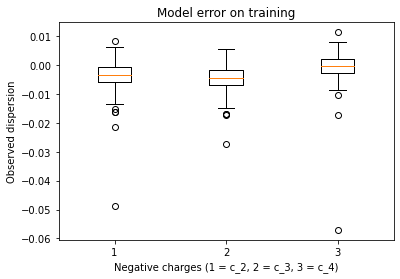

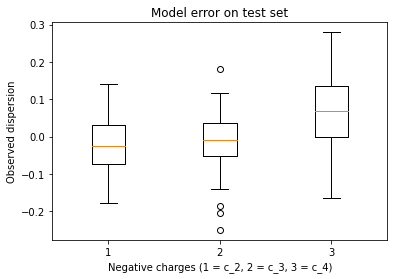

In [15]:
# Plot the dispersion for;
# error during training
plt.figure()
plt.boxplot(error_training_per_epoch)
plt.xlabel("Negative charges (1 = c_2, 2 = c_3, 3 = c_4)")
plt.ylabel("Observed dispersion")
plt.title("Model error on training")
plt.show()

# error on test set
plt.figure()
plt.boxplot(prediction_error)
plt.xlabel("Negative charges (1 = c_2, 2 = c_3, 3 = c_4)")
plt.ylabel("Observed dispersion")
plt.title("Model error on test set")
plt.show()

# Task 3.2

## Data Handling and Preprocessing

In [9]:
# Populate the dataset
simulations_train_3_2 = []
simulations_continued_train_3_2 = []
for i in range(150):
    trajectory = torch.Tensor(simulation_train_task32[i]).type(torch.FloatTensor).cuda()
    trajectory_continuation = torch.Tensor(simulation_continued_train[i]).type(torch.FloatTensor).cuda()
    simulations_train_3_2.append(trajectory)
    simulations_continued_train_3_2.append(trajectory_continuation)

simulations_validation_3_2 = []
simulations_continued_validation_3_2 = []
simulations_test_3_2 = []
simulations_continued_test_3_2 = []
for i in range(100):
    trajectory_validation = torch.Tensor(simulation_valid[i]).type(torch.FloatTensor).cuda()
    trajectory_validation_continuation = torch.Tensor(simulation_continued_valid[i]).type(torch.FloatTensor).cuda()
    simulations_validation_3_2.append(trajectory_validation)
    simulations_continued_validation_3_2.append(trajectory_validation_continuation)
    
    trajectory_test = torch.Tensor(simulation_test[i]).type(torch.FloatTensor).cuda()
    trajectory_test_continuation = torch.Tensor(simulation_continued_test[i]).type(torch.FloatTensor).cuda()
    simulations_test_3_2.append(trajectory_test)
    simulations_continued_test_3_2.append(trajectory_test_continuation)

In [10]:
# Construct dataloaders
train_dataset_3_2 = CustomDataset(simulations_train_3_2, simulations_continued_train_3_2)
train_dataloader_3_2 = DataLoader(train_dataset_3_2, batch_size=1, shuffle=True)

validation_dataset_3_2 = CustomDataset(simulations_validation_3_2, simulations_continued_validation_3_2)
validation_dataloader_3_2 = DataLoader(validation_dataset_3_2, batch_size=1, shuffle=False)

test_dataset_3_2 = CustomDataset(simulations_test_3_2, simulations_continued_test_3_2)
test_dataloader_3_2 = DataLoader(test_dataset_3_2, batch_size=1, shuffle=False)

## Model Implementation

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        
        # One fully connected layer to output 
        self.fc = nn.Linear(hidden_dim, 120)
        
    def forward(self, inputs, h_0, c_0):
        # Forward propagate
        out, (h_n, c_n) = self.lstm(inputs, (h_0, c_0))
        
        # Reshape before forwarding
        output = h_n.view(-1, self.hidden_dim)
        
        # Forward through dense layers
        output = self.fc(output)
        
        # Resize final shape
        output = output.view(60, 2)
        
        return output, h_n, c_n

## Model Training

In [13]:
# User-defined hyperparameters
input_dim = 2
hidden_dim = 256
lstm = LSTM(input_dim, hidden_dim).cuda()

criterion = nn.MSELoss() # Due to being a regression-like problem we use mean squared error
learning_rate = 0.0001
optimizer = torch.optim.Adam(lstm.parameters(), lr = learning_rate)

# Number of epochs to train for
epochs = 200

# Store average loss and std for each epoch
loss_per_epoch = np.empty((epochs, 1))
loss_eval_per_epoch = np.empty((epochs, 1))

for epoch in range(epochs):
    total_loss = 0
    total_eval_loss = 0

    # Set in train mode
    lstm.train()
    
    # Train the model
    training_iterator = iter(train_dataloader_3_2)
    for i in range(len(training_iterator)):
        x, y = next(training_iterator)
        
        # Store the initial and expected trajectories
        initial_trajectory = x[0]
        expected_trajectory = y[0]
        expected_trajectory_len = len(expected_trajectory)
        
        h_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()
        c_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()

        output, hidden, cell = lstm(initial_trajectory, h_n, c_n)

        # Slice unused predictions
        output = output[range(expected_trajectory_len)]

        # Compute loss
        loss = criterion(output, expected_trajectory)

        # Backward propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    # Set in eval mode
    lstm.eval()
    
    # Evaluate the model
    validation_iterator = iter(validation_dataloader_3_2)
    for i in range(len(validation_iterator)):
        x, y = next(validation_iterator)
        
        # Store the initial and expected trajectories
        initial_trajectory = x[0]
        expected_trajectory = y[0]
        expected_trajectory_len = len(expected_trajectory)
        
        h_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()
        c_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()
        
        with torch.no_grad():
            output, hidden, cell = lstm(initial_trajectory, h_n, c_n)
        
            # Slice unused predictions
            output = output[range(expected_trajectory_len)]
            
            # Compute loss
            loss = criterion(output, expected_trajectory)
            total_eval_loss += loss.item()
        
    average_loss = total_loss / len(training_iterator)
    average_eval_loss = total_eval_loss / len(validation_iterator)
    
    # Record for graphing purposes
    loss_per_epoch[epoch] = average_loss
    loss_eval_per_epoch[epoch] = average_eval_loss
    
    print('Epoch:', epoch+1, '\tTraining loss:', average_loss, '\tValidation loss:', average_eval_loss)

Epoch: 1 	Training loss: 2.9359023755788805 	Validation loss: 3.1232806119322776
Epoch: 2 	Training loss: 2.536130556464195 	Validation loss: 2.6615931031107904
Epoch: 3 	Training loss: 2.1511616462469103 	Validation loss: 2.488807129859924
Epoch: 4 	Training loss: 1.9115918960173925 	Validation loss: 2.2254736733436586
Epoch: 5 	Training loss: 1.7863987144827842 	Validation loss: 2.1446633104979993
Epoch: 6 	Training loss: 1.616457681854566 	Validation loss: 1.9648855667561294
Epoch: 7 	Training loss: 1.4643271008878946 	Validation loss: 1.9364519435539842
Epoch: 8 	Training loss: 1.4307970143854618 	Validation loss: 1.7830049588531256
Epoch: 9 	Training loss: 1.3551222225526969 	Validation loss: 1.736449607014656
Epoch: 10 	Training loss: 1.3206712733457486 	Validation loss: 1.6594976492598652
Epoch: 11 	Training loss: 1.202161895831426 	Validation loss: 1.5702148931846023
Epoch: 12 	Training loss: 1.113196273756524 	Validation loss: 1.4460696353018283
Epoch: 13 	Training loss: 1.088

Epoch: 101 	Training loss: 0.08930844362204274 	Validation loss: 0.6269698539283126
Epoch: 102 	Training loss: 0.09901794131845236 	Validation loss: 0.6150549872405827
Epoch: 103 	Training loss: 0.0927782342893382 	Validation loss: 0.6336859683226794
Epoch: 104 	Training loss: 0.10625001889343064 	Validation loss: 0.6421887795254588
Epoch: 105 	Training loss: 0.09243644822388887 	Validation loss: 0.6548473471216858
Epoch: 106 	Training loss: 0.10227710018555324 	Validation loss: 0.6744968648441136
Epoch: 107 	Training loss: 0.09902595681759219 	Validation loss: 0.6948331609927118
Epoch: 108 	Training loss: 0.1666889338257412 	Validation loss: 0.5981795354932546
Epoch: 109 	Training loss: 0.10750376181676984 	Validation loss: 0.6482948302105069
Epoch: 110 	Training loss: 0.11136555989583333 	Validation loss: 0.6727894961182028
Epoch: 111 	Training loss: 0.16065218018367886 	Validation loss: 0.6523475008644164
Epoch: 112 	Training loss: 0.10642981545068324 	Validation loss: 0.60942119644

Epoch: 199 	Training loss: 0.01698560397683953 	Validation loss: 0.611278720330447
Epoch: 200 	Training loss: 0.01808711890519286 	Validation loss: 0.6070420184638351


## Evaluation

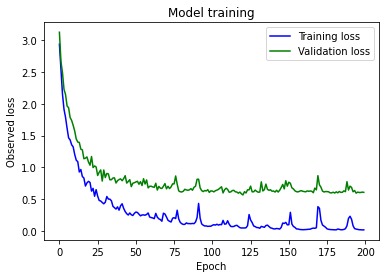

In [14]:
# Plot the loss curve
plt.figure()
plt.plot(range(epochs), loss_per_epoch, "b-", label="Training loss")
plt.plot(range(epochs), loss_eval_per_epoch, "g-", label="Validation loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Observed loss")
plt.title("Model training")
plt.show()

Simulation Index:  44


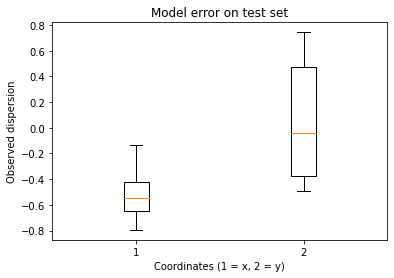

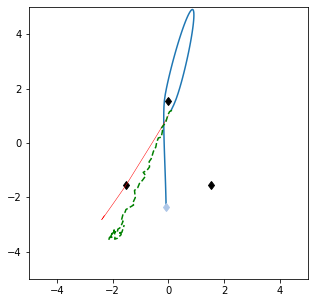

In [43]:
# Evaluate accuracy of the model on test set for a random index
sim_index = random.randint(0, 99)

lstm.eval()

# Problematic cases: 6 73 0
# 'Near' perfect cases: 99 33 13
print('Simulation Index: ', sim_index)

# Get a random simulation sample
initial_trajectory = simulations_test_3_2[sim_index]
expected_trajectory = simulations_continued_test_3_2[sim_index]
expected_trajectory_len = len(expected_trajectory)

h_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()
c_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()

with torch.no_grad():
    output, hidden, cell = lstm(initial_trajectory, h_n, c_n)
    output = output[range(expected_trajectory_len)]

    average_error = expected_trajectory - output
    average_error = average_error.cpu().detach().numpy()

# Plot average dispersion of coordinates
plt.figure()
plt.boxplot(average_error)
plt.xlabel("Coordinates (1 = x, 2 = y)")
plt.ylabel("Observed dispersion")
plt.title("Model error on test set")
plt.show()
    
# Plot trajectory
plot_example(initial_trajectory.cpu().detach().numpy(), expected_trajectory.cpu().detach().numpy(), output.cpu().detach().numpy())

Simulation Index:  27


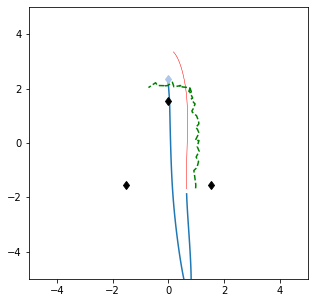

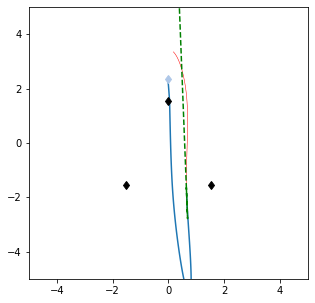

In [84]:
# Linear baseline extrapolation
sim_index = random.randint(0, 99)

lstm.eval()

print('Simulation Index: ', sim_index)

# Get a random simulation sample
initial_trajectory = simulations_test_3_2[sim_index]
expected_trajectory = simulations_continued_test_3_2[sim_index]
expected_trajectory_len = len(expected_trajectory)

h_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()
c_n = torch.randn(1, hidden_dim).type(torch.FloatTensor).cuda()

with torch.no_grad():
    output, hidden, cell = lstm(initial_trajectory, h_n, c_n)
    output = output[range(expected_trajectory_len)]

    average_error = expected_trajectory - output
    average_error = average_error.cpu().detach().numpy()

# Get last two datapoints of the initial trajectory
second_last_position = initial_trajectory[-2].cpu().detach().numpy()
last_position = initial_trajectory[-1].cpu().detach().numpy()
data = np.array([list(second_last_position), list(last_position)])

# Linear fit (use parameter 1 at the end to indicate linear fit)
fit = np.polyfit(data[:,0], data[:,1], 1)
line = np.poly1d(fit)

points = expected_trajectory[:,0].cpu().detach().numpy()
extrapolated_y = line(points)

extrapolated_trajectory = np.empty((expected_trajectory_len, 2))
for i in range(expected_trajectory_len):
    extrapolated_trajectory[i] = [points[i], extrapolated_y[i]]

# Plot trajectory
plot_example(initial_trajectory.cpu().detach().numpy(), expected_trajectory.cpu().detach().numpy(), output.cpu().detach().numpy())

# Plot extrapolation trajectory
plot_example(initial_trajectory.cpu().detach().numpy(), expected_trajectory.cpu().detach().numpy(), extrapolated_trajectory)